In [372]:
# HIDDEN
import warnings
# Ignore numpy dtype warnings. These warnings are caused by an interaction
# between numpy and Cython and can be safely ignored.
# Reference: https://stackoverflow.com/a/40846742
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import nbinteract as nbi

sns.set()
sns.set_context('talk')
np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.set_option('display.max_rows', 7)
pd.set_option('display.max_columns', 8)
pd.set_option('precision', 2)
# This option stops scientific notation for pandas
# pd.set_option('display.float_format', '{:.2f}'.format)

In [373]:
# HIDDEN
def df_interact(df, nrows=7, ncols=7):
    '''
    Outputs sliders that show rows and columns of df
    '''
    def peek(row=0, col=0):
        return df.iloc[row:row + nrows, col:col + ncols]

    row_arg = (0, len(df), nrows) if len(df) > nrows else fixed(0)
    col_arg = ((0, len(df.columns), ncols)
               if len(df.columns) > ncols else fixed(0))
    
    interact(peek, row=row_arg, col=col_arg)
    print('({} rows, {} columns) total'.format(df.shape[0], df.shape[1]))

def display_df(df, rows=pd.options.display.max_rows,
               cols=pd.options.display.max_columns):
    with pd.option_context('display.max_rows', rows,
                           'display.max_columns', cols):
        display(df)

## Decision Boundaries

In [374]:
import sklearn.datasets
data_dict = sklearn.datasets.load_breast_cancer()
cancer = pd.DataFrame(data_dict['data'], columns=data_dict['feature_names'])
cancer['bias'] = 1.0
# Target data_dict['target'] = 0 is malignant; 1 is benign
cancer['malignant'] = 1 - data_dict['target']
cancer

,mean radius,mean texture,mean perimeter,mean area,...,worst symmetry,worst fractal dimension,bias,malignant
0,17.99,10.38,122.80,1001.0,...,0.46,0.12,1.0,1
1,20.57,17.77,132.90,1326.0,...,0.28,0.09,1.0,1
2,19.69,21.25,130.00,1203.0,...,0.36,0.09,1.0,1
...,...,...,...,...,...,...,...,...,...
566,16.60,28.08,108.30,858.1,...,0.22,0.08,1.0,1
567,20.60,29.33,140.10,1265.0,...,0.41,0.12,1.0,1
568,7.76,24.54,47.92,181.0,...,0.29,0.07,1.0,0


In [375]:
df_interact(cancer)

interactive(children=(IntSlider(value=0, description='row', max=569, step=7), IntSlider(value=0, description='…

(569 rows, 32 columns) total


In [376]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(cancer, test_size=0.25, random_state=100)
print("Training Data Size: ", len(train))
print("Test Data Size: ", len(test))

Training Data Size:  426
Test Data Size:  143


In [377]:
train.columns

Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension',
       'bias', 'malignant'],
      dtype='object')

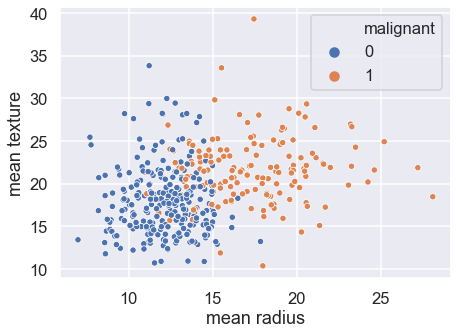

In [378]:
plt.figure(figsize=(7, 5))
sns.scatterplot('mean radius', 'mean texture', hue='malignant',
                s=40, data=train)

In [379]:
from sklearn.linear_model import LogisticRegression

X_train = train[['mean radius', 'mean texture']]
y_train = train['malignant']

clf = LogisticRegression(penalty='none', solver='saga', max_iter=10000)
clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='warn', n_jobs=None, penalty='none',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [380]:
def points_for_boundary(X, clf):
    x_min, x_max = X['mean radius'].agg(['min', 'max'])
    y_min, y_max = X['mean texture'].agg(['min', 'max'])
    xs = np.linspace(x_min, x_max, 100)
    ys = np.linspace(y_min, y_max, 100)
    points = pd.DataFrame({
        'xs': np.tile(xs, len(ys)),
        'ys': np.repeat(ys, len(xs)),
    })
    return points.assign(pred=clf.predict(points))

In [381]:
pred = points_for_boundary(X_train, clf)
pred

,xs,ys,pred
0,6.98,10.38,0
1,7.19,10.38,0
2,7.41,10.38,0
...,...,...,...
9997,27.68,39.28,1
9998,27.90,39.28,1
9999,28.11,39.28,1


In [382]:
def decision_boundary(pred):
    plt.figure(figsize=(12, 6))
    
    plt.subplot(121)
    sns.scatterplot('xs', 'ys', hue='pred', data=pred, alpha=0.2, s=40,
                    legend=False)
    sns.scatterplot('mean radius', 'mean texture', hue='malignant',
                    s=60, legend=False, data=train)
    
    plt.subplot(122)
    sns.scatterplot('xs', 'ys', hue='pred', data=pred, s=40, legend=False)

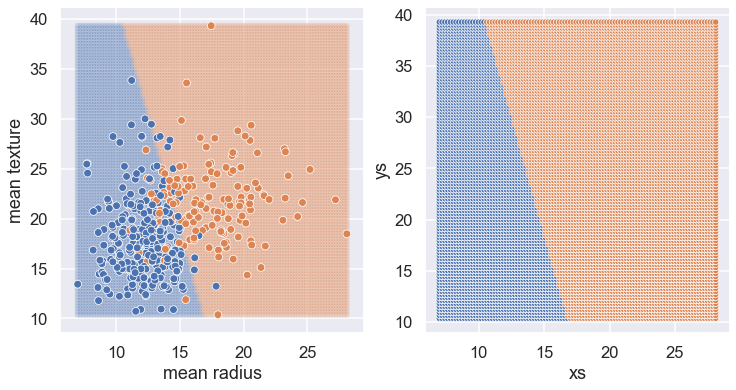

In [398]:
decision_boundary(pred)

In [384]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

In [385]:
def poly_model(degree):
    return make_pipeline(
        PolynomialFeatures(degree=degree, include_bias=False),
        StandardScaler(),
        LogisticRegression(penalty='none', solver='saga', max_iter=10000),
    )

In [386]:
poly2 = poly_model(2)
poly2.fit(X_train, y_train)
poly2.named_steps['logisticregression'].coef_[0]

array([-5.46,  3.75,  7.7 ,  3.84, -4.76])

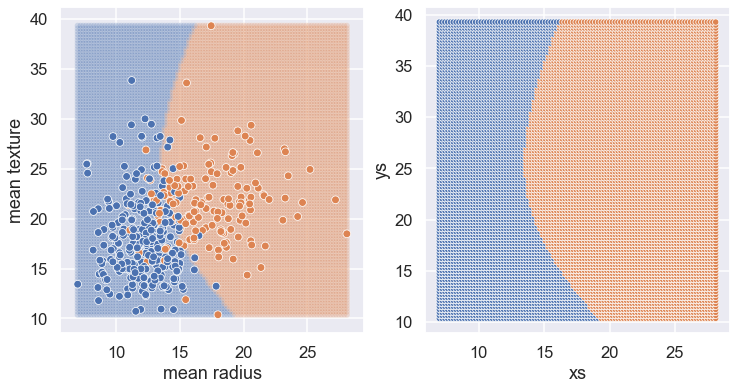

In [387]:
pred2 = points_for_boundary(X_train, poly2)
decision_boundary(pred2)

Remember the k-nearest-neighbors classifier from Data 8?

In [388]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

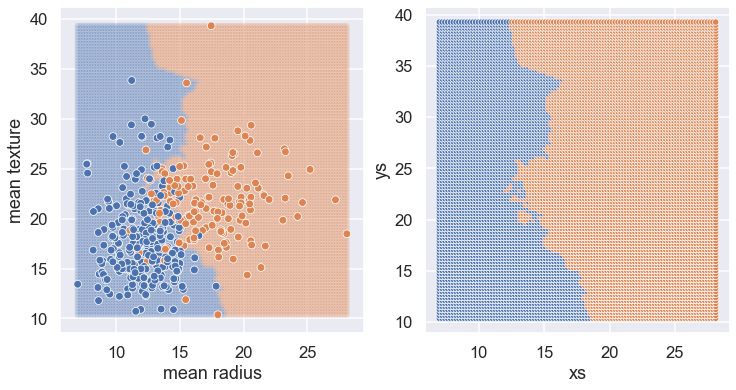

In [389]:
pred_nn = points_for_boundary(X_train, knn)
decision_boundary(pred_nn)

Why won't GD converge on linearly separable data?

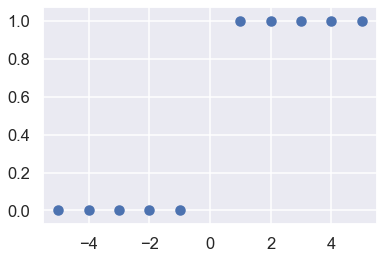

In [490]:
toy = pd.DataFrame({
    'X': [-5, -4, -3, -2, -1, 1, 2, 3, 4, 5],
    'Y': [ 0,  0,  0,  0,  0, 1, 1, 1, 1, 1]
})
plt.scatter(toy['X'], toy['Y']);

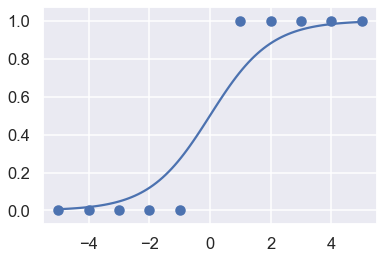

In [494]:
from scipy.special import expit as sigmoid

theta = 1
xs = np.linspace(-5, 5, 100)
ys = sigmoid(theta * xs)

plt.scatter(toy['X'], toy['Y'])
plt.plot(xs, ys);

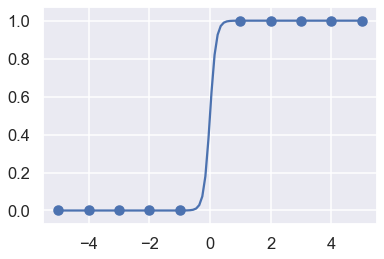

In [495]:
theta = 10
xs = np.linspace(-5, 5, 100)
ys = sigmoid(theta * xs)

plt.scatter(toy['X'], toy['Y'])
plt.plot(xs, ys);

## Validation Curves

In [390]:
cancer

,mean radius,mean texture,mean perimeter,mean area,...,worst symmetry,worst fractal dimension,bias,malignant
0,17.99,10.38,122.80,1001.0,...,0.46,0.12,1.0,1
1,20.57,17.77,132.90,1326.0,...,0.28,0.09,1.0,1
2,19.69,21.25,130.00,1203.0,...,0.36,0.09,1.0,1
...,...,...,...,...,...,...,...,...,...
566,16.60,28.08,108.30,858.1,...,0.22,0.08,1.0,1
567,20.60,29.33,140.10,1265.0,...,0.41,0.12,1.0,1
568,7.76,24.54,47.92,181.0,...,0.29,0.07,1.0,0


In [391]:
X = train.iloc[:, :-1]
y = train.iloc[:, -1]

In [392]:
%%time

from sklearn.linear_model import LogisticRegressionCV

clf = make_pipeline(
    StandardScaler(),
    LogisticRegressionCV(cv=5, solver='saga', max_iter=10000, n_jobs=4),
)
clf.fit(X, y);

CPU times: user 7.48 s, sys: 52.6 ms, total: 7.53 s
Wall time: 3.53 s


In [422]:
def plot_score_curve(scores, column_names, x_axis, y_axis, **kwargs):
    cv = pd.melt(pd.DataFrame(scores, columns=column_names),
                 var_name=x_axis, value_name=y_axis)
    sns.pointplot(x=x_axis, y=y_axis, data=cv, **kwargs)

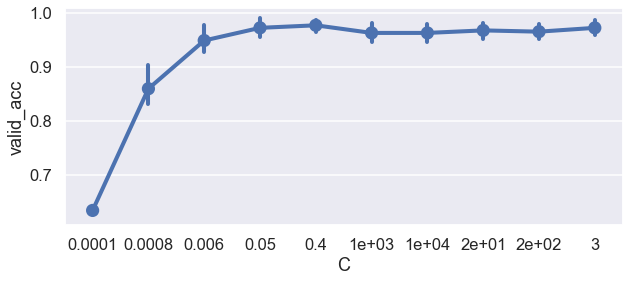

In [419]:
scores = clf.named_steps['logisticregressioncv'].scores_[1]
Cs = [f'{C:.1g}' for C in clf.named_steps['logisticregressioncv'].Cs_]

plt.figure(figsize=(10, 4))
plot_score_curve(scores, Cs, 'C', 'valid_acc')

## Learning Curves

In [434]:
from sklearn.datasets import fetch_california_housing
data = fetch_california_housing()
X = pd.DataFrame(data['data'], columns=data['feature_names'])
y = data['target']
X

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.33,41.0,6.98,1.02,322.0,2.56,37.88,-122.23
1,8.30,21.0,6.24,0.97,2401.0,2.11,37.86,-122.22
2,7.26,52.0,8.29,1.07,496.0,2.80,37.85,-122.24
...,...,...,...,...,...,...,...,...
20637,1.70,17.0,5.21,1.12,1007.0,2.33,39.43,-121.22
20638,1.87,18.0,5.33,1.17,741.0,2.12,39.43,-121.32
20639,2.39,16.0,5.25,1.16,1387.0,2.62,39.37,-121.24


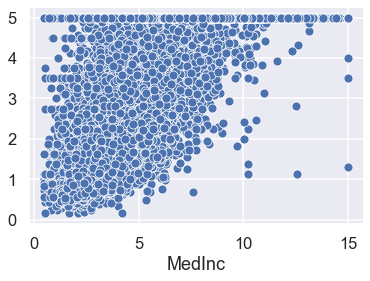

In [438]:
sns.scatterplot(X['MedInc'], y)

In [478]:
from sklearn.model_selection import learning_curve
from sklearn.linear_model import Ridge

train_sizes, train_scores, valid_scores = learning_curve(
    Ridge(alpha=0.0001), X, y, train_sizes=np.arange(1000, 17000, 1000),
    scoring='neg_mean_squared_error', cv=5)

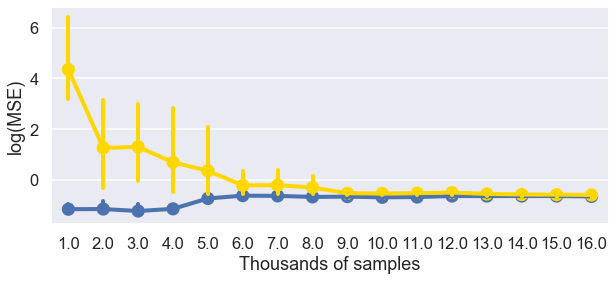

In [480]:
plt.figure(figsize=(10, 4))
plot_score_curve(np.log(-train_scores.T), train_sizes / 1000,
                 'Thousands of samples', 'training_acc')
plot_score_curve(np.log(-valid_scores.T), train_sizes / 1000,
                 'Thousands of samples', 'valid_acc', color='gold')
plt.ylabel('log(MSE)');

## Regularized Logistic Regression

As with linear regression, one common way of reducing the variance of the parameter estimator is to add a regularization term to the empirical risk objective. E.g.,

\begin{align*}
R(\beta, x, y, \lambda) &= - \frac{1}{n}\sum_{i=1}^n \left[ y_i x_i^T\beta + \log \sigma(-x_i^T\beta) \right] + \frac{1}{2} C \sum_{j=1}^J \beta_j^2 \\[10pt]
\nabla_{\beta} R(\beta, x, y, \lambda) &=  - \frac{1}{n}\sum_{i=1}^n \left(y_i - \sigma(x_i^T\beta)\right) x_i + C \beta \\[10pt]
\end{align*}

In [ ]:
def regularized_logistic_regression(x, y, c):
    """Train a logistic regression classifier using gradient descent."""

    def l2_regularized_gradient(beta, x, y):
        return risk_gradient(beta, x, y) + c * beta

    beta0 = np.zeros(x.shape[0])
    beta = gradient_descent(x, y, beta0, l2_regularized_gradient)
    return beta    

def search_for_c(features):
    for c in 2.0 ** np.arange(-10, 10, 2):
        print("c =", c)
        beta = regularized_logistic_regression(features(train), y_train, c)
        print("sum(beta**2) = ", sum(beta**2))
        evaluate(beta, features)
        print()
        
search_for_c(all_features)

In [ ]:
from sklearn import preprocessing

def inputs(t):
    return t.drop('malignant', axis=1).values

scaler = preprocessing.StandardScaler().fit(inputs(train))

def scaled_features(t):
    return scaler.transform(inputs(t)).T

search_for_c(scaled_features)

In [ ]:
model = LogisticRegression(C=4, solver='lbfgs')
model.fit(scaled_features(train).T, y_train)
y_hat = model.predict(scaled_features(test).T)
print_ratio(sum(y_hat == y_test), len(y_test))

### Multiclass classification

\begin{align*}
P(Y=y|X) &= \frac{\exp(X^T\beta_{y})}{\sum_{z=0}^d \exp(X^T\beta_z)} \\[10pt]
L(\beta_0,\dots,\beta_d, x_i, y_i) &= - \log \frac{\exp(x_i^T\beta_{y_i})}{\sum_{z=0}^d \exp(x_i^T\beta_z)} \\[10pt]
\frac{\partial}{\partial \beta_w} L(\beta_0,\dots,\beta_d, x_i, y_i) &= -\left(1[w=y_i] - \frac{\exp(x_i^T\beta_w)}{\sum_{z=0}^d \exp(x_i^T\beta_z)}\right) x_i  \\[10pt]
1[w=y_i] &= \begin{cases}
1 & \text{if}\ w=y_i \\
0 & \text{otherwise}
\end{cases}
\end{align*}


In [ ]:
data_dict = sklearn.datasets.load_iris()
x = pd.DataFrame(data_dict['data'], columns=data_dict['feature_names'])
y = data_dict['target']
x.describe()

In [ ]:
np.unique(y, return_counts=True)